# Simulation of Empirical Results

In [1]:
import pandas as pd
import numpy as np
from numpy.linalg import cholesky
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from scipy.interpolate import BSpline, splrep, splev
import tensorflow as tf
from tensorflow import keras
from sklearn.datasets import fetch_openml
import urllib.request
import os
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import seaborn as sns
import torch.optim as optim
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
import skfda
from skfda.datasets import fetch_tecator, fetch_growth
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

2026-01-07 06:51:22.183711: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-07 06:51:22.220485: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-07 06:51:23.106342: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


## Simulation Study

In [2]:
# we set R = 1 to focus only on the complexity of the relationship between 
# a function and the response variable.
np.random.seed(2026)
torch.manual_seed(2026)
n_iterations = 100
# time grid 
m = 200
t = np.linspace(0, 1, m)
dt = t[1] - t[0]

# Covariance Matérn (ν = 5/2)
def matern52_cov(t, rho=0.5, sigma=1.0):
    T1, T2 = np.meshgrid(t, t)
    r = np.abs(T1 - T2)
    sqrt5_r = np.sqrt(5) * r / rho
    return sigma**2 * (1 + sqrt5_r + 5*r**2/(3*rho**2)) * np.exp(-sqrt5_r)


In [3]:
# Simulation of function Xi(t)

def simulate_functions(n, t):
    cov = matern52_cov(t)
    L = cholesky(cov + 1e-6*np.eye(len(t)))
    Z = np.random.randn(n, len(t))
    return Z @ L.T


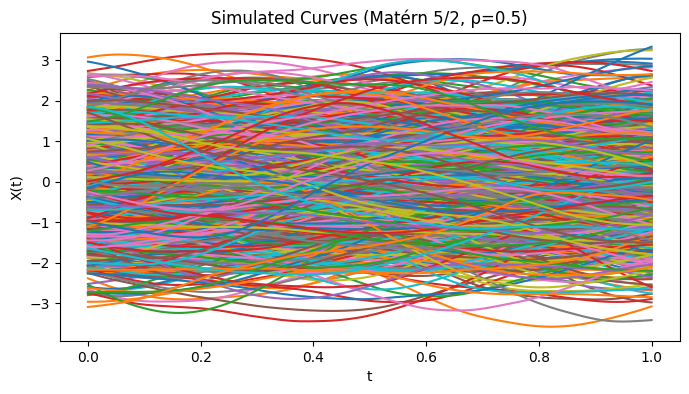

In [15]:
# visualisation of simulated curves of predictors

# Parameters
n_sim = 1500
m = 200
t = np.linspace(0, 1, m)

# Simulation
K = matern52_cov(t)
L = np.linalg.cholesky(K + 1e-8 * np.eye(m))
curves = np.random.standard_normal((n_sim, m)) @ L.T

# Plot
plt.figure(figsize=(8, 4))
for i in range(n_sim):
    plt.plot(t, curves[i, :])
plt.title("Simulated Curves (Matérn 5/2, ρ=0.5)")
plt.xlabel("t")
plt.ylabel("X(t)")
plt.savefig('simulated_curves.png', dpi=300, bbox_inches='tight')
plt.show()

##### y is a continuous response

In [5]:
# Scenarios of true relation between Y ansd Xi(t) with continuous response and a single predictor function.

def scenario_linear(X):
    beta = 5 * np.sin(2*np.pi*t)
    return (X @ beta) * dt + np.random.randn(len(X))

def scenario_cam(X):
    return np.sum(X**2, axis=1) * dt + np.random.randn(len(X))

def scenario_single_index(X):
    beta = 5 * np.sin(2*np.pi*t)
    z = (X @ beta) * dt
    return z**2 + np.random.randn(len(X))

def scenario_multiple_index(X):
    beta1 = 5 * np.sin(2*np.pi*t)
    beta2 = 5 * np.sin(3*np.pi*t)
    z1 = (X @ beta1) * dt
    z2 = (X @ beta2) * dt
    return z1**2 + z2**2 + np.random.randn(len(X))

# Double integral of beta1(t)beta2(s)X(t)X(s) = (Intégrale beta1*X) * (Intégrale beta2*X)
def scenario_quadratic(X):
    beta1 = 5 * np.sin(3 * np.pi * t)
    beta2 = 5 * np.sin(np.pi * t)
    
    # Linear part: integral(beta1(t) * X(t))
    lin = (X @ beta1) * dt
    
    # quadratic part : integral_double(beta1(t)beta2(s)X(t)X(s) ds dt)
    # Mathématically, cela se simplifie en : [integral(beta1*X)] * [integral(beta2*X)]
    quad = ((X @ beta1) * dt) * ((X @ beta2) * dt)
    
    return lin + quad + np.random.randn(len(X))

def scenario_complex_quadratic(X):
    # f1 = integral(X(t)^2 dt)
    term1 = (X**2 @ np.ones(m)) * dt
    
    # f2 = integral_double( (X(t)X(s))^2 ds dt )
    # Simplification : integral(X(t)^2 dt) * integral(X(s)^2 ds)
    # car (X(t)X(s))^2 = X(t)^2 * X(s)^2
    integral_x_sq = (X**2 @ np.ones(m)) * dt
    term2 = integral_x_sq**2
    
    return term1 + term2 + np.random.randn(len(X))

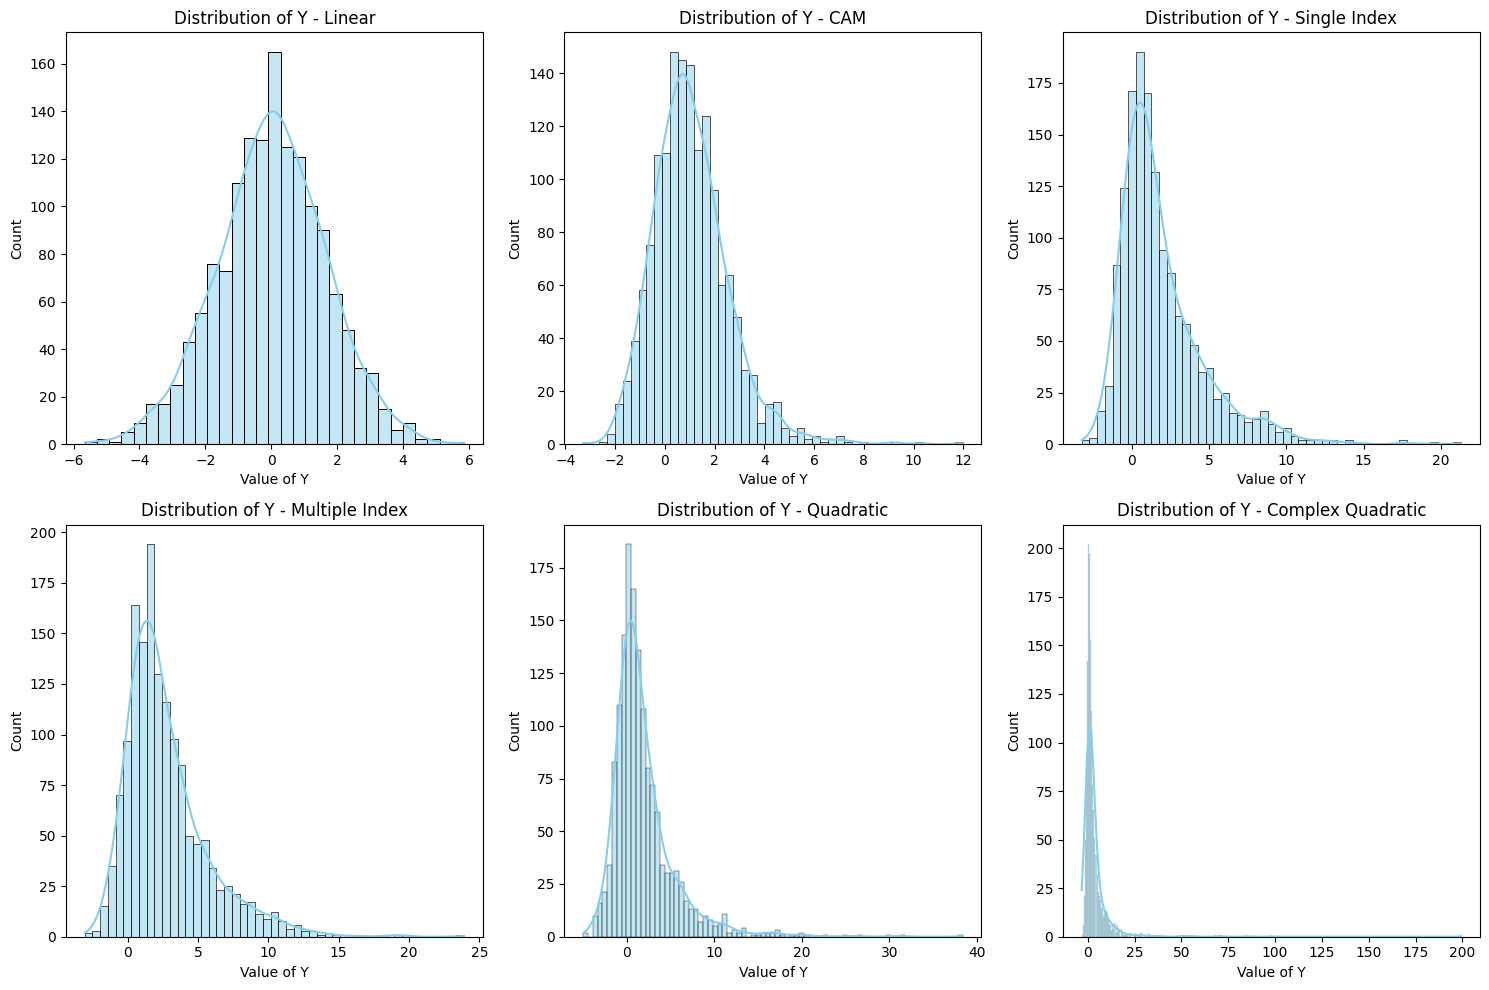

In [6]:
def plot_scenarios_distribution(X, t):
    scenarios = {
        "Linear": scenario_linear(X),
        "CAM": scenario_cam(X),
        "Single Index": scenario_single_index(X),
        "Multiple Index": scenario_multiple_index(X),
        "Quadratic": scenario_quadratic(X),
        "Complex Quadratic": scenario_complex_quadratic(X)
    }
    
    plt.figure(figsize=(15, 10))
    for i, (name, y) in enumerate(scenarios.items(), 1):
        plt.subplot(2, 3, i)
        sns.histplot(y, kde=True, color='skyblue')
        plt.title(f"Distribution of Y - {name}")
        plt.xlabel("Value of Y")
        
    plt.tight_layout()
    plt.show()

n = 1500
X = simulate_functions(n_sim, t)
plot_scenarios_distribution(X, t)


In [7]:
# implementation of model CAM

class CAM_Model(BaseEstimator, RegressorMixin):
    def __init__(self, dt):
        self.dt = dt
        self.model = LinearRegression()

    def fit(self, X, y):
        # Feature CAM : integral X(t)^2 dt
        Z = np.sum(X**2, axis=1).reshape(-1, 1) * self.dt
        self.model.fit(Z, y)
        return self

    def predict(self, X):
        Z = np.sum(X**2, axis=1).reshape(-1, 1) * self.dt
        return self.model.predict(Z)


In [8]:
# implementation of FNN 

fnn_model = Pipeline([
    ('pca', PCA(n_components=10)), # On garde les 10 principales composantes (comme souvent en FDA)
    ('mlp', MLPRegressor(hidden_layer_sizes=(100, 100), max_iter=500, early_stopping=True))
])

In [9]:
# implementation of FDNN 
class FDNN_Model(nn.Module):
    def __init__(self, m, hidden_neurons=64):
        super(FDNN_Model, self).__init__()
        # Couche "Directe" : on apprend beta(t)
        self.functional_layer = nn.Linear(m, hidden_neurons)
        self.activation = nn.ReLU()
        self.output_layer = nn.Linear(hidden_neurons, 1)
        
    def forward(self, x):
        # x shape: (batch, m)
        # Simulation de l'intégrale directe : (X * beta) * dt
        dt = 1.0 / x.shape[1]
        out = self.functional_layer(x) * dt
        out = self.activation(out)
        return self.output_layer(out)

In [10]:
# implementation of FBNN model

def get_bspline_basis(m, n_bases=10):
    # Generate a matrix of B-spline of lenght (m, n_bases)
    knots = np.linspace(0, 1, n_bases + 4) # 4 pour l'ordre cubique
    basis_matrix = np.zeros((m, n_bases))
    t_grid = np.linspace(0, 1, m)
    for i in range(n_bases):
        coeffs = np.zeros(n_bases)
        coeffs[i] = 1
        spline = BSpline(knots, coeffs, 3)
        basis_matrix[:, i] = spline(t_grid)
    return torch.tensor(basis_matrix, dtype=torch.float32)

class FBNN_Model(nn.Module):
    def __init__(self, m, n_bases=10, hidden_neurons=64):
        super(FBNN_Model, self).__init__()
        self.basis_matrix = get_bspline_basis(m, n_bases) # (m, n_bases)
        # Only the spline coefficients are learned.
        self.basis_coeffs = nn.Parameter(torch.randn(n_bases, hidden_neurons))
        self.activation = nn.ReLU()
        self.output_layer = nn.Linear(hidden_neurons, 1)

    def forward(self, x):
        # We reconstruct beta(t) from the bases
        beta = self.basis_matrix @ self.basis_coeffs # (m, hidden_neurons)
        # Integral : X @ beta * dt
        dt = 1.0 / x.shape[1]
        out = (x @ beta) * dt
        out = self.activation(out)
        return self.output_layer(out)

In [11]:
# comparison of models 

# wrapper to make fdnn compatible with the loop
 
class TorchWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, model_class, m, lr=0.01, epochs=100, patience = 10):
        self.model_class = model_class
        self.m = m
        self.lr = lr
        self.epochs = epochs
        self.patience = patience
        self.model = None

    def fit(self, X_train, y_train, X_val=None, y_val=None):
        self.model = self.model_class(self.m)
        optimizer = optim.Adam(self.model.parameters(), lr=self.lr)
        criterion = nn.MSELoss()
        
        X_train = torch.tensor(X_train, dtype=torch.float32)
        y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)

        if X_val is not None:
            X_val = torch.tensor(X_val, dtype=torch.float32)
            y_val = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)

        best_val = np.inf
        patience_counter = 0

        for epoch in range(self.epochs):
            self.model.train()
            optimizer.zero_grad()
            loss = criterion(self.model(X_train), y_train)
            loss.backward()
            optimizer.step()

            if X_val is not None:
                self.model.eval()
                with torch.no_grad():
                    val_loss = criterion(self.model(X_val), y_val).item()

                if val_loss < best_val:
                    best_val = val_loss
                    patience_counter = 0
                else:
                    patience_counter += 1

                if patience_counter >= self.patience:
                    break

        return self


    
    def predict(self, X):
        self.model.eval()
        with torch.no_grad():
            X_t = torch.tensor(X, dtype=torch.float32)
            return self.model(X_t).numpy().flatten()


scenarios = {
    "Linear": scenario_linear,
    "CAM": scenario_cam,
    "Single Index": scenario_single_index,
    "Multiple Index": scenario_multiple_index,
    "Quadratic": scenario_quadratic,
    "Complex Quadratic": scenario_complex_quadratic
}

models = {
    # approximation of FLM (Functional Linear Model)
    "Linear Regression": LinearRegression(),
    "CAM": CAM_Model(dt=dt),
    # classic neural network
    "Neural Network": MLPRegressor(hidden_layer_sizes=(100, 100),
                                   max_iter=500,
                                   early_stopping=True),
    "FNN": fnn_model,
    # "FNN": "Modèle avec base de fonctions (ex: Fourier/B-splines)",
    "FDNN": TorchWrapper(FDNN_Model, m=200),
    "FBNN": TorchWrapper(FBNN_Model, m=200)
}

print(f"Starting {n_iterations} iterations for each scenario...")

all_results = []

for iteration in range(n_iterations):
    # Generate new X features at each iteration for variability
    X = simulate_functions(n_sim, t)
    
    for scen_name, scen_func in scenarios.items():
        # Generate the Y response for this scenario
        y = scen_func(X)
        
            # Split article
        X_train, X_test = X[:1000], X[1000:]
        y_train, y_test = y[:1000], y[1000:]

        # Split validation (deep learning)
        X_tr, X_val = X_train[:500], X_train[500:]
        y_tr, y_val = y_train[:500], y_train[500:]
        
        for model_name, model in models.items():
            if "FDNN" in model_name or "FBNN" in model_name:
                model.fit(X_train, y_train,
                        X_val=X_val, y_val=y_val)
            else:
                model.fit(X_train, y_train)

            y_pred = model.predict(X_test)
            rmse = np.sqrt(mean_squared_error(y_test, y_pred))

            print(scen_name, model_name, rmse)

            all_results.append({
                "Iteration": iteration,
                "Scenario": scen_name,
                "Model": model_name,
                "RMSE": rmse
            })
    
    if (iteration + 1) % 10 == 0:
        print(f"Iteration {iteration + 1}/{n_iterations} completed.")



Starting 100 iterations for each scenario...
Linear Linear Regression 1.1550816280249117
Linear CAM 1.7559183562522505
Linear Neural Network 1.0492687899333462
Linear FNN 1.0775447651968213


/home/ensai/Documents/MSD/FDA/FDA---Non-linear-Functional-Modeling-using-Neural-Networks/venv/lib/python3.10/site-packages/torch/autograd/graph.py:841: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:119.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Linear FDNN 1.1081871622653974
Linear FBNN 1.2103618226845276
CAM Linear Regression 1.6519520034192583
CAM CAM 1.0091294414697312
CAM Neural Network 1.058208621406558
CAM FNN 1.0848287144324988
CAM FDNN 1.1706362153993617
CAM FBNN 1.1434961766356744
Single Index Linear Regression 3.2480667815639723
Single Index CAM 2.7115578494160935
Single Index Neural Network 1.270818610826094
Single Index FNN 1.208192470996192
Single Index FDNN 1.6006834393177902
Single Index FBNN 1.8922130943953046
Multiple Index Linear Regression 3.684082692276348
Multiple Index CAM 2.808560380075494
Multiple Index Neural Network 1.3250075444617526
Multiple Index FNN 1.1183732413797804
Multiple Index FDNN 1.7635456081089738
Multiple Index FBNN 1.874860312813754
Quadratic Linear Regression 3.5785742453894462
Quadratic CAM 2.092778678083373
Quadratic Neural Network 1.2191873349004436
Quadratic FNN 1.2091088519839726
Quadratic FDNN 2.3649589067815624
Quadratic FBNN 1.8090628205381256
Complex Quadratic Linear Regressi

In [12]:
results_df = pd.DataFrame(all_results)
results_df.head()

summary_rmse = (
    results_df
    .groupby(["Scenario", "Model"])["RMSE"]
    .mean()
    .reset_index()
)

table_2article = summary_rmse.pivot(
    index="Scenario",
    columns="Model",
    values="RMSE"
)

scenario_order = [
    "Linear",
    "CAM",
    "Single Index",
    "Multiple Index",
    "Quadratic",
    "Complex Quadratic"
]

table_2article = table_2article.loc[scenario_order]

model_order = [
    "Linear Regression",
    "CAM",
    "Neural Network",
    "FNN",
    "FDNN",
    "FBNN"
]

table_2article = table_2article[model_order]

table_2article.columns = ["FLM", "CAM", "NN", "FNN", "FDNN", "FBNN"]
table_2article = table_2article.round(3)
table_2article


,FLM,CAM,NN,FNN,FDNN,FBNN
Scenario,,,,,,
Linear,1.117,1.736,1.021,1.024,1.044,1.109
CAM,1.644,1.001,1.084,1.089,1.173,1.149
Single Index,3.339,2.868,1.254,1.244,1.681,1.951
Multiple Index,3.581,2.843,1.261,1.241,1.886,2.076
Quadratic,3.682,2.193,1.324,1.281,2.124,1.883
Complex Quadratic,7.431,2.746,3.897,3.322,4.963,5.111


##### y is a binary response

In [11]:
# Scenarios of true relation between Y ansd Xi(t) with binary response and a single predictor function.

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def generate_binary_y(eta):
    # Transformation en probabilité puis tirage de Bernoulli (0 ou 1)
    p = sigmoid(eta)
    return np.random.binomial(1, p)

# Binary Scenarios

def scenario_logistic_binary(X):
    beta = 5 * np.sin(2 * np.pi * t)
    eta = (X @ beta) * dt
    return generate_binary_y(eta)

def scenario_cam_binary(X):
    # f(Xi,t) = sin(Xi(t))
    eta = np.sum(np.sin(X), axis=1) * dt
    return generate_binary_y(eta)

def scenario_single_index_binary(X):
    beta = 5 * np.sin(2 * np.pi * t)
    a = (X @ beta) * dt
    eta = np.sin(a)
    return generate_binary_y(eta)

def scenario_multiple_index_binary(X):
    beta1 = 5 * np.sin(2 * np.pi * t)
    beta2 = 5 * np.sin(3 * np.pi * t)
    a = (X @ beta1) * dt
    b = (X @ beta2) * dt
    eta = np.sin(np.sin(a) + b)
    return generate_binary_y(eta)

def scenario_quadratic_binary(X):
    beta1 = 5 * np.sin(3 * np.pi * t)
    beta2 = 5 * np.sin(np.pi * t)
    lin = (X @ beta1) * dt
    # Interaction : integral(beta1*X) * integral(beta2*X)
    quad = ((X @ beta1) * dt) * ((X @ beta2) * dt)
    eta = lin + quad
    return generate_binary_y(eta)

def scenario_complex_quadratic_binary(X):
    # f1 = integral(sin(X(t)) dt)
    term1 = np.sum(np.sin(X), axis=1) * dt
    # f2 = integral_double(sin(X(t)*X(s)) ds dt)
    # Note: For the binary complex, the double integral is more cumbersome.  
    # It can be approximated by a sum if m is not too large.
    # To remain efficient: 
    integral_sin_x = np.sum(np.sin(X), axis=1) * dt
    term2 = integral_sin_x**2 # Approche de la structure d'interaction
    eta = term1 + term2
    return generate_binary_y(eta)

In [12]:
# implementation of 6 methods 

scenarios = {
    "Logistic": scenario_logistic_binary,
    "CAM": scenario_cam_binary,
    "Single Index": scenario_single_index_binary,
    "Multiple Index": scenario_multiple_index_binary,
    "Quadratic": scenario_quadratic_binary,
    "Complex Quadratic": scenario_complex_quadratic_binary
}


# CAM Classifier 
class CAMClassifier(BaseEstimator, ClassifierMixin):
    def fit(self, X, y):
        Z = np.sum(np.sin(X), axis=1).reshape(-1, 1) * dt
        self.model = LogisticRegression(max_iter=1000)
        self.model.fit(Z, y)
        return self

    def predict(self, X):
        Z = np.sum(np.sin(X), axis=1).reshape(-1, 1) * dt
        return self.model.predict(Z)
    

# FDNN / FBNN (binary)
class FDNN_Binary(nn.Module):
    def __init__(self, m, hidden=64):
        super().__init__()
        self.fc = nn.Linear(m, hidden)
        self.act = nn.ReLU()
        self.out = nn.Linear(hidden, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.act(self.fc(x) * dt)
        return self.sigmoid(self.out(x))

def get_bspline_basis(m, n_bases=10):
    knots = np.linspace(0, 1, n_bases + 4)
    t_grid = np.linspace(0, 1, m)
    basis = np.zeros((m, n_bases))
    for i in range(n_bases):
        c = np.zeros(n_bases)
        c[i] = 1
        basis[:, i] = BSpline(knots, c, 3)(t_grid)
    return torch.tensor(basis, dtype=torch.float32)

class FBNN_Binary(nn.Module):
    def __init__(self, m, n_bases=10, hidden=64):
        super().__init__()
        self.B = get_bspline_basis(m, n_bases)
        self.coeffs = nn.Parameter(torch.randn(n_bases, hidden))
        self.act = nn.ReLU()
        self.out = nn.Linear(hidden, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        beta = self.B @ self.coeffs
        x = self.act((x @ beta) * dt)
        return self.sigmoid(self.out(x))

class TorchClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, model_class, m, lr=0.01, epochs=100):
        self.model_class = model_class
        self.m = m
        self.lr = lr
        self.epochs = epochs

    def fit(self, X, y):
        self.model = self.model_class(self.m)
        opt = optim.Adam(self.model.parameters(), lr=self.lr)
        loss_fn = nn.BCELoss()

        X_t = torch.tensor(X, dtype=torch.float32)
        y_t = torch.tensor(y, dtype=torch.float32).view(-1, 1)

        for _ in range(self.epochs):
            opt.zero_grad()
            loss = loss_fn(self.model(X_t), y_t)
            loss.backward()
            opt.step()
        return self

    def predict(self, X):
        with torch.no_grad():
            p = self.model(torch.tensor(X, dtype=torch.float32))
        return (p.numpy().flatten() > 0.5).astype(int)


In [13]:
# wrapper with binary classification 


class TorchWrapperBinary(BaseEstimator, ClassifierMixin):
    def __init__(self, model_class, m, lr=0.001, epochs=200, patience=10):
        self.model_class = model_class
        self.m = m
        self.lr = lr
        self.epochs = epochs
        self.patience = patience

    def fit(self, X_tr, y_tr, X_val, y_val):
        self.model = self.model_class(self.m)
        opt = optim.Adam(self.model.parameters(), lr=self.lr)
        loss_fn = nn.BCELoss()

        X_tr = torch.tensor(X_tr, dtype=torch.float32)
        y_tr = torch.tensor(y_tr, dtype=torch.float32).view(-1, 1)
        X_val = torch.tensor(X_val, dtype=torch.float32)
        y_val = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)

        best_loss = np.inf
        counter = 0

        for _ in range(self.epochs):
            opt.zero_grad()
            loss = loss_fn(self.model(X_tr), y_tr)
            loss.backward()
            opt.step()

            with torch.no_grad():
                val_loss = loss_fn(self.model(X_val), y_val)

            if val_loss < best_loss:
                best_loss = val_loss
                best_state = deepcopy(self.model.state_dict())
                counter = 0
            else:
                counter += 1
                if counter >= self.patience:
                    break

        self.model.load_state_dict(best_state)
        return self

    def predict(self, X):
        with torch.no_grad():
            X = torch.tensor(X, dtype=torch.float32)
            return (self.model(X).numpy().flatten() > 0.5).astype(int)


In [14]:
# models 

models = {
    "FLM": LogisticRegression(max_iter=1000),
    "CAM": CAMClassifier(),
    "NN": MLPClassifier(hidden_layer_sizes=(100,100), max_iter=500),
    "FNN": Pipeline([
        ('pca', PCA(n_components=10)),
        ('mlp', MLPClassifier(hidden_layer_sizes=(100,100), max_iter=500))
    ]),
    "FDNN": TorchClassifier(FDNN_Binary, m),
    "FBNN": TorchClassifier(FBNN_Binary, m)
}


# Simulation loop

results = []

for _ in range(100):
    X = simulate_functions(n, t)

    for scen_name, scen_fun in scenarios.items():
        y = scen_fun(X)

        X_tr, X_val, X_te = X[:500], X[500:1000], X[1000:]
        y_tr, y_val, y_te = y[:500], y[500:1000], y[1000:]

        for name, model in models.items():
            if isinstance(model, TorchWrapperBinary):
                model.fit(X_tr, y_tr, X_val, y_val)
            else:
                model.fit(np.vstack((X_tr, X_val)), np.hstack((y_tr, y_val)))

            y_pred = model.predict(X_te)
            err = 1 - accuracy_score(y_te, y_pred)

            results.append([scen_name, name, err])

df = pd.DataFrame(results, columns=["Scenario", "Model", "Error"])
table3 = df.groupby(["Scenario", "Model"]).mean().unstack()
print(table3.round(3))


/home/ensai/Documents/MSD/FDA/FDA---Non-linear-Functional-Modeling-using-Neural-Networks/venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ensai/Documents/MSD/FDA/FDA---Non-linear-Functional-Modeling-using-Neural-Networks/venv/lib/python3.10/site-packages/torch/autograd/graph.py:841: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:119.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
/home/ensai/Documents/MSD/FDA/FDA---Non-linear-Functional-Modeling-using-Neural-Networks/venv/lib/python3.10/site-packages/sklearn/neural_network

                   Error                                   
Model                CAM   FBNN   FDNN    FLM    FNN     NN
Scenario                                                   
CAM                0.388  0.396  0.394  0.395  0.460  0.444
Complex Quadratic  0.401  0.406  0.404  0.407  0.447  0.436
Logistic           0.496  0.287  0.277  0.277  0.344  0.330
Multiple Index     0.430  0.384  0.379  0.380  0.435  0.420
Quadratic          0.324  0.277  0.281  0.328  0.304  0.292
Single Index       0.499  0.380  0.370  0.375  0.435  0.416


### Real Data 

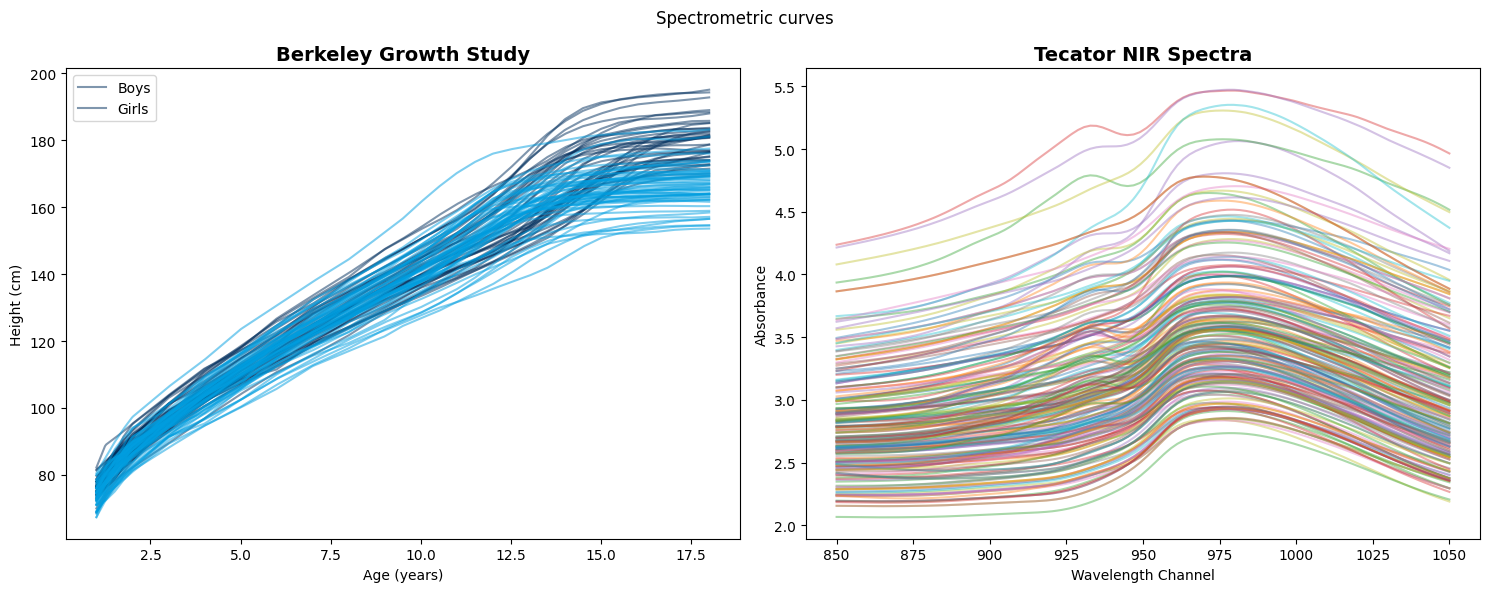

Growth: 93 samples, 31 time points
Tecator: 215 samples, 100 wavelengths


In [ ]:
# Loading of the three datasets : Fat Spectrum, Growth curves and Phonemes Curves 


# Berkeley Growth Study (Classification: Boys vs Girls)
growth = fetch_growth()
X_growth = growth.data  # Objects FDataGrid (format fonctionnel)
y_growth = growth.target

# TECATOR (Regression: Fat Content)
tecator = fetch_tecator()
X_tecator = tecator.data
y_tecator = tecator.target

fig, axes = plt.subplots(1, 2, figsize=(15, 6))



# Graphique 1 : Growth Study
# We seperate boys and girls on the color 

colors_growth = ['#002E5D' if g == 0 else '#009EE0' for g in y_growth]
X_growth.plot(axes=axes[0], group=y_growth, group_colors=['#002E5D', '#009EE0'], alpha=0.5)
axes[0].set_title("Berkeley Growth Study", fontsize=14, fontweight='bold')
axes[0].set_xlabel("Age (years)")
axes[0].set_ylabel("Height (cm)")
axes[0].legend(['Boys', 'Girls'])

# Graphique 2 : Tecator Spectrometric 
# A color gradient based on fat content (target) is used.
X_tecator.plot(axes=axes[1], alpha=0.4)
axes[1].set_title("Tecator NIR Spectra", fontsize=14, fontweight='bold')
axes[1].set_xlabel("Wavelength Channel")
axes[1].set_ylabel("Absorbance")

plt.tight_layout()
plt.show()

# Affichage des infos pour ton Beamer 
print(f"Growth: {X_growth.n_samples} samples, {X_growth.grid_points[0].shape[0]} time points")
print(f"Tecator: {X_tecator.n_samples} samples, {X_tecator.grid_points[0].shape[0]} wavelengths")